# Systematic Literature Review DX in Shipping - Thematic Analysis

Note: We can only do thematic analysis on title, since for the abstract we have inverted abstract and we are not capable of properly rebulding it

In [3]:
#!pip install spacy

In [4]:
#!python -m spacy download en_core_web_md

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import DocBin

from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer

from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
#import numpy as np
#print(hasattr(np, 'typing'))

In [31]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
# substring = 'title'
# # List all column names containing the substring using list comprehension
# matching_columns = [k for k in lit.columns if substring in k]
# print(matching_columns)
# #lit['title']

## Read the DB in

In [33]:
# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [34]:
# Keep only columns whose names contain the substring, modify in-place
lit = lit[['title']]
lit = lit.dropna(subset=["title"])

In [35]:
print(lit.count())

title    2290
dtype: int64


In [36]:
lit.head(5)

,title
0,Predictive Analysis of Maritime Congestion Usi...
1,VerifAI: Framework for Functional Verification...
2,Emerging trends in signal processing and machi...
3,Effectiveness of Problem-based Learning (PBL) ...
4,Enhancing Leafy Greens’ Production: Nutrient F...


## Thematic analysis

In [38]:
# Load spaCy's English tokenizer
nlp = spacy.load('en_core_web_sm')

# Preprocess a column (e.g., 'abstract' or 'title') in the dataset
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in STOP_WORDS]
    return " ".join(tokens)

In [39]:
# Apply preprocessing to the relevant column (e.g., 'title' and 'abstract')
lit['cleaned_title'] = lit['title'].apply(preprocess_text)  # or 'title', depending on your focus

In [40]:
# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and get embeddings for each document
inputs = tokenizer(lit['cleaned_title'].tolist(), padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Averaging the token embeddings

In [41]:
print(len(embeddings[0]))

768


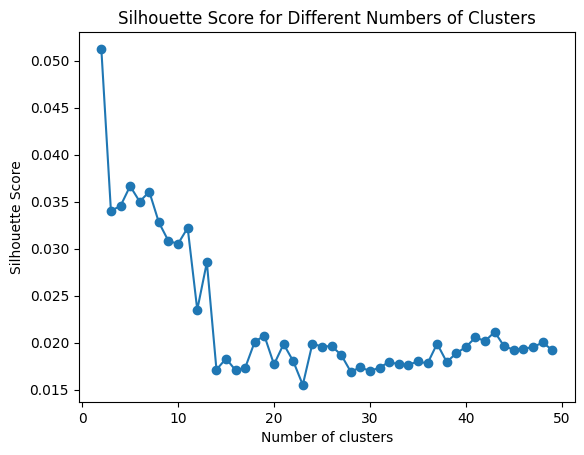

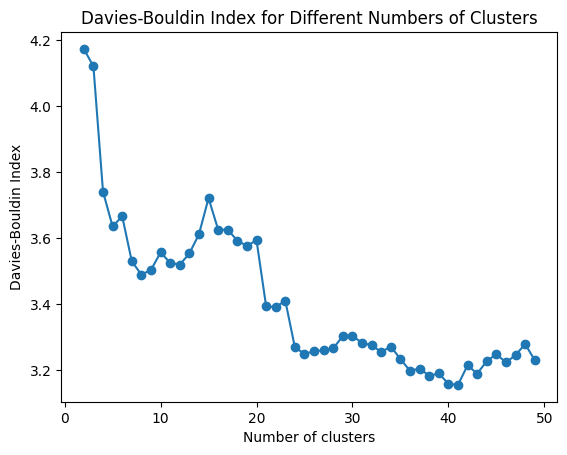

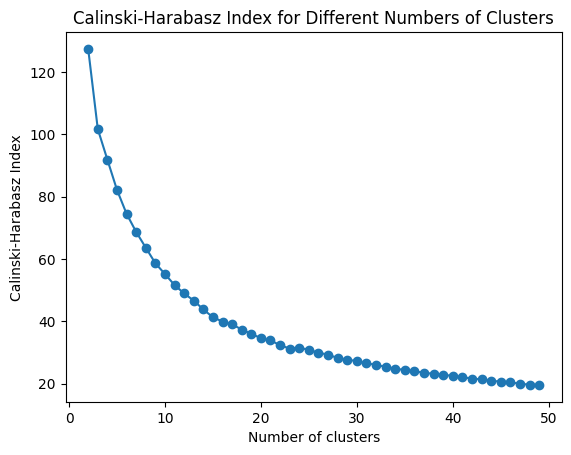

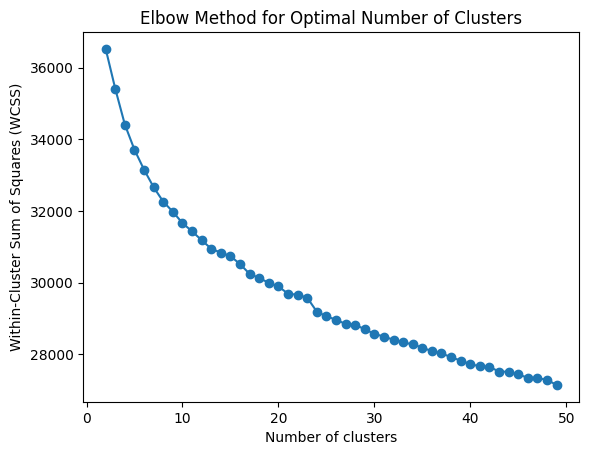

In [42]:
# Try different numbers of clusters

max_n_clusters = 50

from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(range(2, max_n_clusters), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

from sklearn.metrics import davies_bouldin_score
db_scores = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = davies_bouldin_score(embeddings, labels)
    db_scores.append(score)

# Plot Davies-Bouldin scores
plt.plot(range(2, max_n_clusters), db_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.show()

from sklearn.metrics import calinski_harabasz_score
# List to store Calinski-Harabasz scores for different numbers of clusters
ch_scores = []
# Define range for number of clusters
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(embeddings)
    score = calinski_harabasz_score(embeddings, labels)
    ch_scores.append(score)

# Plot Calinski-Harabasz scores
plt.plot(range(2, max_n_clusters), ch_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Numbers of Clusters')
plt.show()

# Calculate WCSS for each number of clusters in range
wcss = []
for k in range(2, max_n_clusters):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)  # WCSS for each cluster count

# Plot WCSS for each cluster count to visualize the elbow
plt.plot(range(2, max_n_clusters), wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [43]:
# Detect Topics

# Apply KMeans clustering to the embeddings
kmeans = KMeans(n_clusters=8)
labels = kmeans.fit_predict(embeddings)

# Add the predicted topics to the dataframe
lit['topic'] = labels

# Get cluster centroids from the KMeans model
from sklearn.metrics import pairwise_distances
centroids = kmeans.cluster_centers_

# For each cluster, find the documents closest to the centroid
num_representatives = 5  # Number of representative documents per topic
for i in range(kmeans.n_clusters):
    # Get the indices of documents in the current cluster
    cluster_docs_idx = np.where(labels == i)[0]
    
    # Calculate distances to the centroid for documents in the cluster
    distances = pairwise_distances(embeddings[cluster_docs_idx], centroids[i].reshape(1, -1))
    
    # Sort documents by proximity to centroid and select top N closest
    closest_docs_idx = cluster_docs_idx[distances.flatten().argsort()[:num_representatives]]
    
    # Display the closest document titles for interpretation
    print(f"\nTopic {i + 1}:")
    for idx in closest_docs_idx:
        print(f"  - {lit['title'].iloc[idx]}")


Topic 1:
  - A data mining-then-predict method for proactive maritime traffic management by machine learning
  - An Intelligent Algorithm for USVs Collision Avoidance Based on Deep Reinforcement Learning Approach with Navigation Characteristics
  - A benchmark study on ship speed prediction models in arctic conditions: Machine learning, process-based and hybrid approaches
  - A novel object-oriented Bayesian network on risk assessment of sea lanes of communication
  - A Machine-Learning Approach Based on Attention Mechanism for Significant Wave Height Forecasting

Topic 2:
  - Adaptive multi-source data fusion vessel trajectory prediction model for intelligent maritime traffic
  - Grid-Based Bayesian Bootstrap Approach for Real-Time Detection of Abnormal Vessel Behaviors From AIS Data in Maritime Logistics
  - Link Quality Enhancement with Beamforming Using Kalman-based Motion Tracking for Maritime Communication
  - Artificial intelligence techniques for small boats detection in radar

## Keyword analysis in abstract and title

In [45]:
# need to read lit again to keep abstract this time

# Read in the file
#lit = pd.read_csv('C:/projects/dx_in_shipping/openalex_data_final.csv')
lit = pd.read_csv('./openalex_data.csv',low_memory=False)

In [46]:
# This cell is useful to check columns in the db. To be used only after having loaded the pandas df
substring = 'abstract_inverted_index'
# List all column names containing the substring using list comprehension
matching_columns = [k for k in lit.columns if substring in k]
matching_columns.append('title')
print(matching_columns)
#lit['title']

['abstract_inverted_index_The_0', 'abstract_inverted_index_The_1', 'abstract_inverted_index_maritime_0', 'abstract_inverted_index_maritime_1', 'abstract_inverted_index_maritime_2', 'abstract_inverted_index_industry_0', 'abstract_inverted_index_is_0', 'abstract_inverted_index_is_1', 'abstract_inverted_index_one_0', 'abstract_inverted_index_of_0', 'abstract_inverted_index_of_1', 'abstract_inverted_index_of_2', 'abstract_inverted_index_of_3', 'abstract_inverted_index_of_4', 'abstract_inverted_index_of_5', 'abstract_inverted_index_of_6', 'abstract_inverted_index_the_0', 'abstract_inverted_index_the_1', 'abstract_inverted_index_the_2', 'abstract_inverted_index_the_3', 'abstract_inverted_index_the_4', 'abstract_inverted_index_the_5', 'abstract_inverted_index_the_6', 'abstract_inverted_index_the_7', 'abstract_inverted_index_most_0', 'abstract_inverted_index_crucial_0', 'abstract_inverted_index_sectors_0', 'abstract_inverted_index_in_0', 'abstract_inverted_index_global_0', 'abstract_inverted_i

In [47]:
lit = lit[matching_columns]

In [48]:
# prepare a function to extract keyword from column name

def extract_keyword(row, colnames):
    words = []
    for c in colnames:
        if pd.notnull(row[c]):
            csplit = c.split('_')
            if len(csplit) > 3:
                words.append(csplit[3])
    return ' '.join(words)

In [49]:
lit['full_abstract_words'] = lit.apply(lambda row: extract_keyword(row,matching_columns), axis=1)

In [50]:
lit = lit[['title', 'full_abstract_words']]

In [51]:
lit.loc[:, 'full_text'] = lit.apply(lambda row: f"{row['title']} {row['full_abstract_words']}", axis=1)

In [52]:
lit = lit [['full_text']]

In [53]:
# clean full_text

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Function to clean and preprocess text
def preprocess_text(text):
    doc = nlp(text)  # Process text with spaCy
    clean_words = [
        token.lemma_.lower() for token in doc  # Lemmatize and lowercase
        if not token.is_stop  # Remove stopwords
        and not token.is_punct  # Remove punctuation
    ]
    return ' '.join(clean_words)

# Apply the cleaning function to both columns
lit.loc[:, 'cleaned_text'] = lit['full_text'].apply(preprocess_text)

In [54]:
lit['cleaned_text']

0       predictive analysis maritime congestion dynami...
1       verifai framework functional verification ai b...
2       emerge trend signal processing machine learnin...
3       effectiveness problem base learning pbl mariti...
4       enhance leafy greens production nutrient film ...
                              ...                        
2321    novel bias tsp algorithm maritime patrol marit...
2322    ship collision avoidance base vulnerability as...
2323    pmbm filtering fusion target provide exterocep...
2324    research thrust allocation power positioning s...
2325    scan issue maritime maritime global ship impro...
Name: cleaned_text, Length: 2326, dtype: object

In [78]:
# We now perform key extraction in different ways

# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

# Use TfidfVectorizer to extract keywords
vectorizer = TfidfVectorizer(max_df=0.8, min_df = 2, stop_words='english', max_features=1000)  # Adjust max_df and max_features as needed
tfidf_matrix = vectorizer.fit_transform(lit['cleaned_text'])
tfidf_feature_names = vectorizer.get_feature_names_out()

# Show top N keywords per document based on TF-IDF score
top_n = 10  # Adjust the number of keywords you want
top_keywords = []

# For each document, get the top N keywords based on TF-IDF scores
for row in tfidf_matrix:
    # Zip the TF-IDF scores with feature names, and filter only terms with scores > 0 for the document
    sorted_items = sorted([(score, feature) for score, feature in zip(row.toarray().flatten(), tfidf_feature_names) if score > 0], reverse=True)
    keywords = [item[1] for item in sorted_items[:top_n]]
    top_keywords.append(keywords)

# Add keywords as a new column in the dataframe
lit['top_keywords'] = top_keywords
lit.head(5)

,full_text,cleaned_text,top_keywords
0,Predictive Analysis of Maritime Congestion Usi...,predictive analysis maritime congestion dynami...,"[prediction, analysis, feature, traffic, dynam..."
1,VerifAI: Framework for Functional Verification...,verifai framework functional verification ai b...,"[functional, ai, systems, domain, framework, b..."
2,Emerging trends in signal processing and machi...,emerge trend signal processing machine learnin...,"[special, signal, trend, processing, emerge, n..."
3,Effectiveness of Problem-based Learning (PBL) ...,effectiveness problem base learning pbl mariti...,"[learning, effectiveness, problem, base, marit..."
4,Enhancing Leafy Greens’ Production: Nutrient F...,enhance leafy greens production nutrient film ...,"[urban, production, food, container, automatio..."


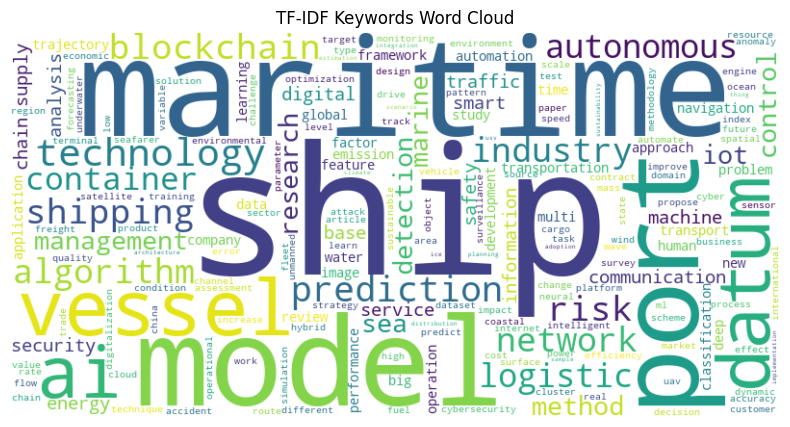

In [82]:
from wordcloud import WordCloud

# Combine all keywords into a single list for each method (TF-IDF and BERT)
tfidf_keywords = [word for keywords in lit['top_keywords'] for word in keywords]

# Convert lists to a single string for word cloud generation
tfidf_keywords_text = " ".join(tfidf_keywords)

# Generate and plot the TF-IDF Word Cloud
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white").generate(tfidf_keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Keywords Word Cloud")
plt.show()

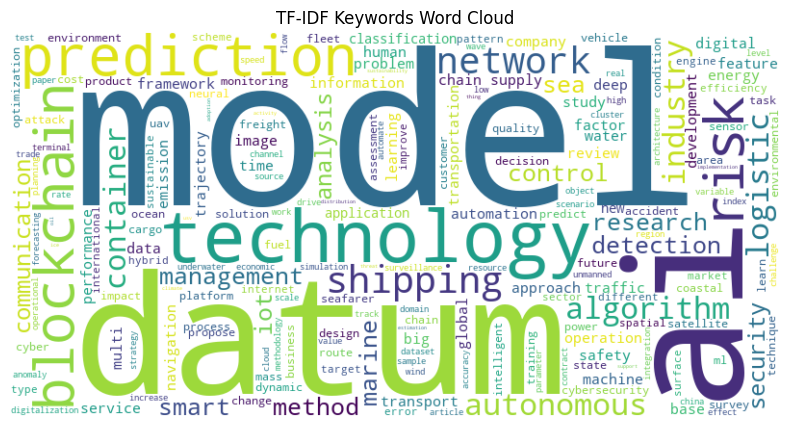

In [88]:
# Cloud of words removing strong ship-related words

remove_words = ['maritime', 'ship', 'vessel', 'port']

# Combine all keywords into a single list for each method (TF-IDF and BERT)
tfidf_keywords = [word for keywords in lit['top_keywords'] for word in keywords if word not in remove_words]

# Convert lists to a single string for word cloud generation
tfidf_keywords_text = " ".join(tfidf_keywords)

# Generate and plot the TF-IDF Word Cloud
wordcloud_tfidf = WordCloud(width=800, height=400, background_color="white").generate(tfidf_keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tfidf, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Keywords Word Cloud")
plt.show()